In [1]:
import pandas
import math
%matplotlib inline

rename_dict = {}
for i in range(1995, 2015):
    rename_dict[' ' + str(i)] = str(i)
    
country_code2country = {}
f = open("who-mortality/country_codes.csv")
f.readline()
for s in f.readlines():
    splitted = s.rstrip().split(',')
    code = splitted[0]
    name = ','.join(splitted[1:])
    country_code2country[int(code)] = name
f.close()


sex2int = {"Persons" : 3, "Male" : 1, "Female" : 2}

In [2]:
disease = pandas.read_excel("who-desease-burden/GHE2015_YLD-2015-country.xls", sheet_name=1, header=6)
mortality = pandas.read_csv("who-mortality/mort-no-nan-col.csv")
causes_of_death = pandas.read_csv("who-mortality/causes-of-death.csv", sep=";")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
i = 0
def choose_last_value(a):
    a, b, c, d = a
    if pandas.notnull(d):
        return d
    elif pandas.notnull(c):
        return c
    elif pandas.notnull(b):
        return b
    return a


In [4]:
mortality["Country"] = mortality["Country"].map(country_code2country.get)

In [5]:
health_exp = pandas.read_csv("who-health-expenditure/exp-years-percent.csv", header=1)
health_exp = health_exp.rename(columns=rename_dict)
health_exp = health_exp.set_index("Country")

In [6]:
disease_names = disease.loc[:, "GHE cause":"Member State\n(See Notes for explanation of colour codes)"]
disease["Name"] = disease_names.apply(choose_last_value, axis=1)
basic = disease[disease["GHE cause"].notnull()]
basic["Sex"] = pandas.DataFrame(basic["Sex"].map(sex2int))
basic = basic.drop(basic.loc[:, "Unnamed: 2": "Member State\n(See Notes for explanation of colour codes)"].columns, axis=1)
basic = basic[basic["Sex"].notnull()]
basic = basic.set_index("Name").transpose()

#basic = disease.loc[:, "Afghanistan":"Zimbabwe"][2:15]
#basic = basic.transpose()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


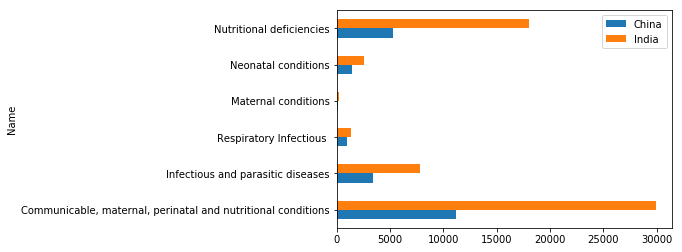

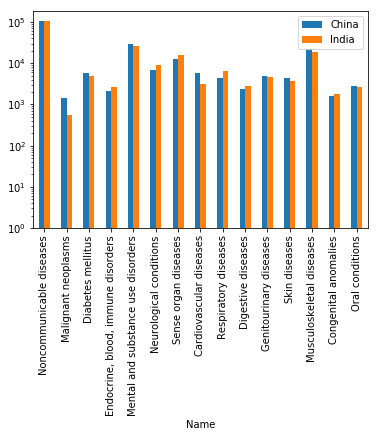

In [7]:
for i in basic.columns:
    try:
        basic[i] = pandas.to_numeric(basic[i])
        basic[i + " r"] = basic[i] / basic["Population (\'000) (2)"] * 1000
    except:
        del basic[i]
        
        


filtered_small = basic[basic.iloc[:, 1] < 100000]
#filtered_small.plot.scatter(x="Population ('000) (2)", y="Digestive diseases")
filtered_large = basic[basic.iloc[:, 1] > 100000].transpose()

filtered_large_comm = filtered_large.iloc[2:8] # all communicable diseases
filtered_large_comm.plot.barh(by = ["China", "India"])

filtered_large_ncomm = filtered_large.loc["Noncommunicable diseases":"Oral conditions"]
filtered_large_ncomm.plot.bar(by = ["China", "India"], log=True)

В Индии население немногим меньше, чем в Китае, в обеих странах более миллиарда жителей. Сравним показатели заболеваемостей.

* Первый график -- заразные заболевания, и на графике видно, что в Индии во всех категориях таких заболеваний больных в 2-4 раза больше.
* Второй график -- незаразные заболевания (логарифмическая шкала, чтобы лучше видеть), здесь совсем другая ситуация, заболевших примерно поровну (всего), но выделяется колонка "Злокачественные новообразования", значение для Китая больше в 3 раза!


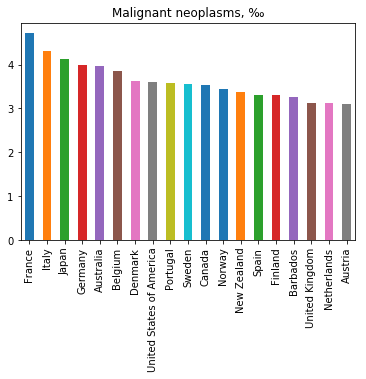

In [15]:
oncology = basic.sort_values(by="Malignant neoplasms r", ascending = False)
max_relative_neoplasms = oncology.iloc[1:20] #first is sex (garbage)
max_relative_neoplasms.plot.bar(by = "", y="Malignant neoplasms r", legend=False, title="Malignant neoplasms, ‰")

Мы видим, что больше всего люди страдают от злокачественных опухолей в продвинутых, экономически благополучных европейских странах. Барбадос?


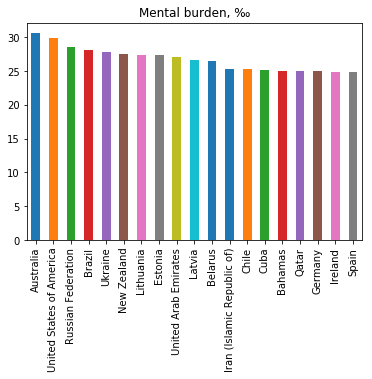

In [14]:
mental_disorders = basic.sort_values(by="Mental and substance use disorders r", ascending = False)
max_relative_mental_burden = mental_disorders.iloc[1:20] #first is sex (garbage)
max_relative_mental_burden.plot.bar(by = "", y="Mental and substance use disorders r", legend=False, title="Mental burden, ‰")

В этом графике очень много стран бывшего Советского Союза по сравнению с предыдущим


In [9]:
burden_and_expenditure = (basic.transpose().append(health_exp["2014"])).transpose()
burden_and_expenditure = (burden_and_expenditure.transpose().append(health_exp["2009"])).transpose()

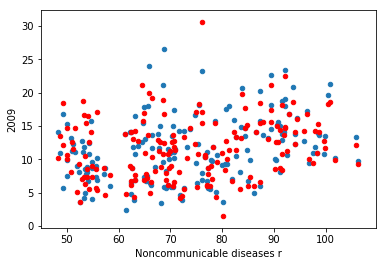

In [10]:
noncomm_expenditure = burden_and_expenditure.plot.scatter(x="Noncommunicable diseases r", y='2014')
burden_and_expenditure.plot.scatter(x="Noncommunicable diseases r", y='2009', ax=noncomm_expenditure, color="red")

Вложения в медицину не дают ощутимого результата, хм.

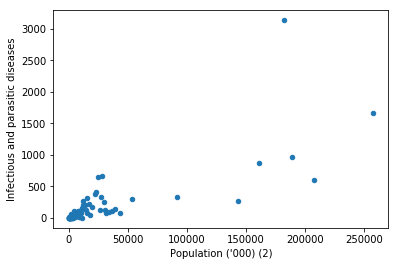

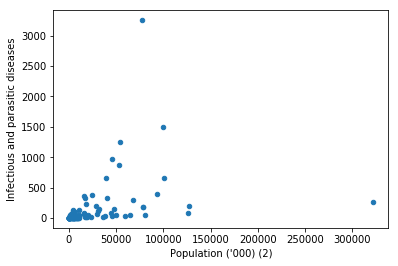

In [11]:
filtered_bae = burden_and_expenditure[burden_and_expenditure["Population (\'000) (2)"] < 1000000]
filtered_bae[10 > filtered_bae['2014']].plot.scatter(x="Population ('000) (2)", y="Infectious and parasitic diseases")
filtered_bae[10 <= filtered_bae['2014']].plot.scatter(x="Population ('000) (2)", y="Infectious and parasitic diseases")
#filtered_bae

Графики (страны разделены по низкому бюджету медицины и высокому), на которых видим, что в двух странах очень сильные всплески инфекционных заболеваний, что же это за страны?

In [12]:
filtered_bae[filtered_bae["Infectious and parasitic diseases"] > 2000]

Name,Population ('000) (2),All Causes,"Communicable, maternal, perinatal and nutritional conditions",Infectious and parasitic diseases,Respiratory Infectious,Maternal conditions,Neonatal conditions,Nutritional deficiencies,Noncommunicable diseases,Malignant neoplasms,...,Genitourinary diseases r,Skin diseases r,Musculoskeletal diseases r,Congenital anomalies r,Oral conditions r,Injuries r,Unintentional injuries r,Intentional injuries r,2014,2009
Democratic Republic of the Congo,77267.0,8826.190780,4385.637341,3254.203609,117.850021,22.874782,86.007184,904.701745,4103.496904,27.499229,...,2.221148,2.889003,7.077162,0.969804,1.553043,4.362231,3.948021,0.414210,11.06,18.69
Nigeria,182202.0,17221.356446,6259.598770,3137.938561,178.064189,63.141386,217.853307,2662.601328,9833.365459,64.733101,...,2.667187,2.441389,7.835746,0.720120,1.151731,6.193084,5.533613,0.659471,8.17,7.37


Странно, что сюда не попали другие африканские страны